In [180]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
plt.rcParams['figure.figsize'] = [20, 10]

In [16]:
os.getcwd()

'/Users/casbertrams/Documents/GitHub/DSP/cas/notebooks'

In [10]:
dataPath = '/Users/casbertrams/Documents/GitHub/DSP/data/data3'
caseCount = len(os.listdir(dataPath))
data = []
try:
    os.remove(dataPath + ".DS_Store")
except:
    print("No file DS_Store")
for filename in os.listdir(dataPath):
    f = open(os.path.join(dataPath, filename), encoding='utf-8')
    data.append([filename.replace('.txt', ''), f.read()])

verdict_df = pd.DataFrame(data, columns=['Case ID', 'Case Text'])
cases_df = pd.read_csv('/Users/casbertrams/Documents/GitHub/DSP/cas/csv/cases3.csv', usecols = ['GerechtelijkProductType', 'Case ID', 'Proceduresoorten', 'Publicatiedatum', 'Rechtsgebieden', 'Tekstfragment', 'Titel', 'Uitspraakdatum', 'UitspraakdatumType'])
merged_df = cases_df.join(verdict_df.set_index('Case ID'), on='Case ID', how='left')


No file DS_Store


In [13]:
def count_cases(word_arr):
    dates = []
    counts = []
    for i in range(len(merged_df)):
        current = merged_df.iloc[i]
        current_date = current['Uitspraakdatum']
        current_case_text = current['Case Text']
        occurrences = 0
        if any(x.lower() in current_case_text.lower() for x in word_arr):
            occurrences = 1
        dates.append(current_date)
        counts.append(occurrences)
    
    dates = pd.Series(dates)
    counts = pd.Series(counts)
    frame = { 'date': dates, 'count': counts}
    results = pd.DataFrame(frame)
    return results

In [158]:
def count_mentions(word_arr):
    dates = []
    counts = []
    for i in range(len(merged_df)):
        current = merged_df.iloc[i]
        current_date = current["Uitspraakdatum"]
        
        current_case_text = current['Case Text']
        occurrences = 0
        for i in word_arr:
            occurrences = occurrences + current_case_text.lower().count(i.lower())
        dates.append(current_date)
        counts.append(occurrences)

    dates = pd.Series(dates)
    counts = pd.Series(counts)
    frame = { 'date': dates, 'count': counts, 'type': word_arr[0] }
    results = pd.DataFrame(frame)
    return results

In [165]:
mdma_results = count_cases(['XTC', 'ecstacy', 'mdma'])
mdma_results.set_index('date', inplace=True)
mdma_results.index = pd.to_datetime(mdma_results.index)
daily_mdma_result = mdma_results.resample('1D').sum()
monthly_mdma_result = mdma_results.resample('1M').sum()

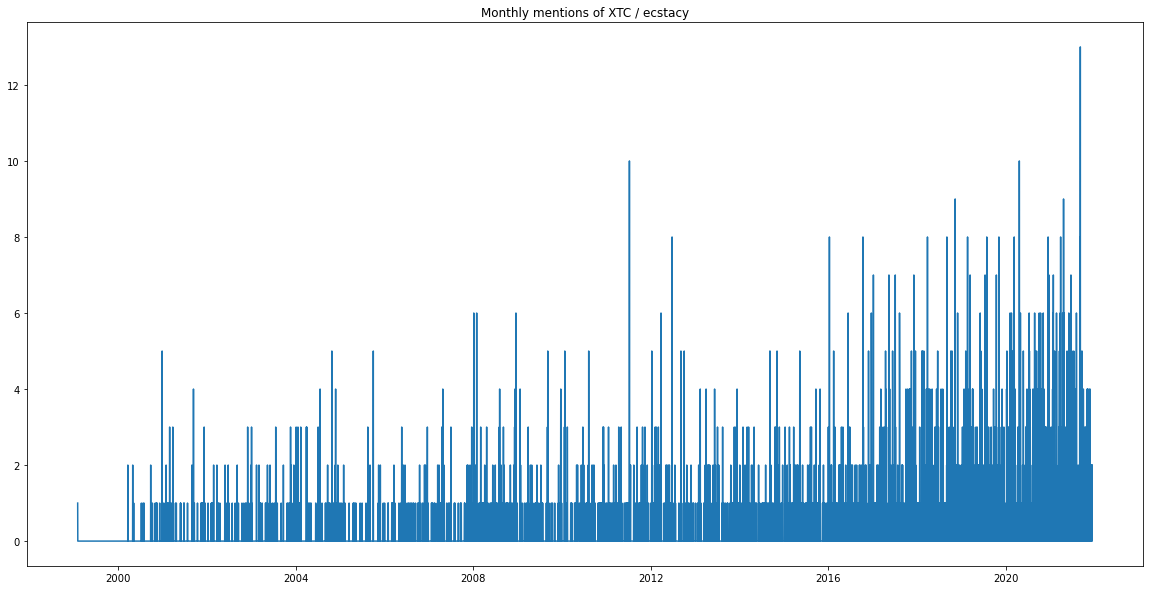

In [166]:
daily_mdma_result = daily_mdma_result[next((i for i, v in enumerate(daily_mdma_result['count']) if v != 0), -1):]
monthly_mdma_result = monthly_mdma_result[next((i for i, v in enumerate(daily_mdma_result['count']) if v != 0), -1):]
plt.plot(daily_mdma_result)
plt.title("Monthly mentions of XTC / ecstacy")
plt.show()

<h4>Create train / test split </h4>

In [167]:
mdma_train_index = int(len(daily_mdma_result) * 0.8)
mdma_train = daily_mdma_result[:mdma_train_index]
mdma_test = daily_mdma_result[mdma_train_index:]

print(len(mdma_train))
print(len(mdma_test))

6680
1671


<h2>Naive<h2>

2.6128623520682783


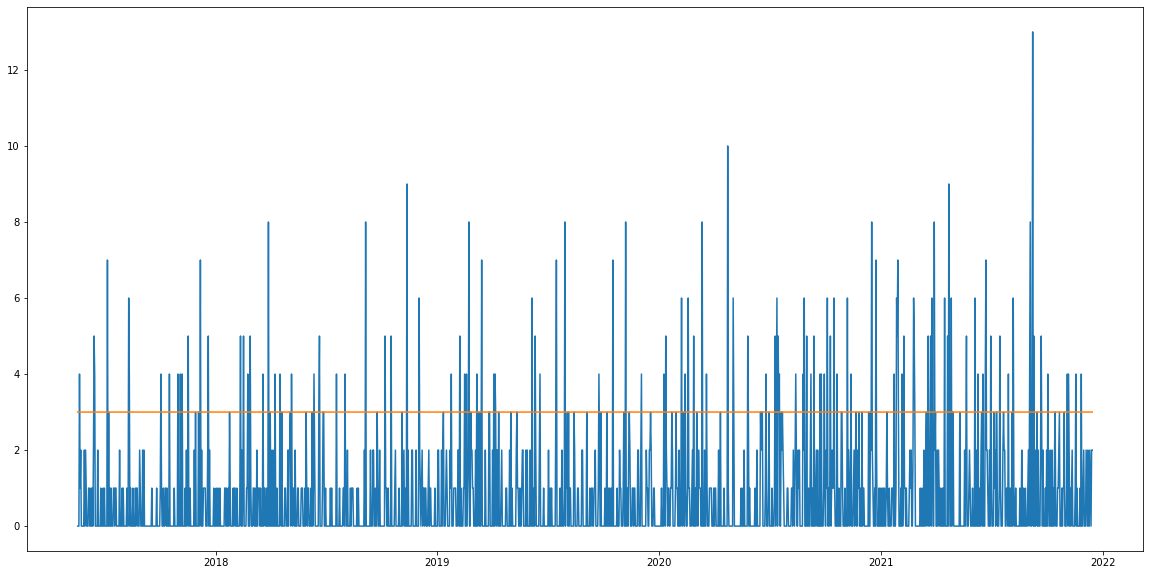

In [168]:
curr_fc = []
naive_score = mdma_train['count'].iloc[-1]

for i in range(len(mdma_test)):
    curr_fc.append(naive_score)

fc_df = pd.DataFrame(data=curr_fc, index=mdma_test.index)
rms = mean_squared_error(mdma_test, fc_df, squared=False)
print(rms)
plt.plot(mdma_test)
plt.plot(fc_df)
plt.show()

<h2>Arima</h2>

1.7242918209948486


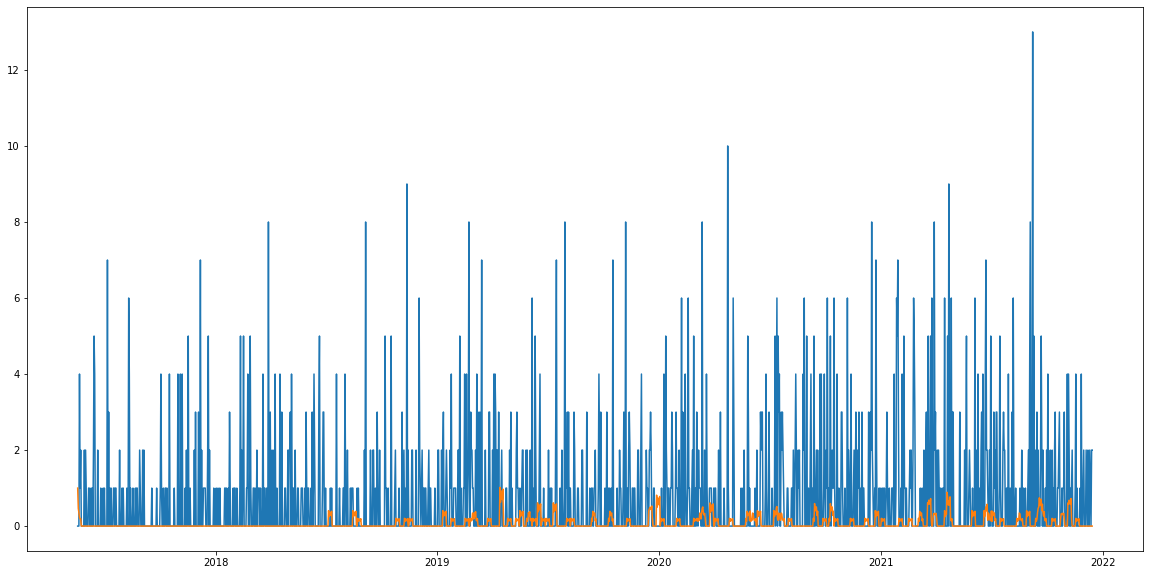

In [174]:
model1 = ARIMA(mdma_train, order=(5,1,0))
res = model1.fit()
curr_fc = round(res.predict(1, len(mdma_test)), 4)
mask = pd.to_numeric(curr_fc, errors='coerce').lt(0)
curr_fc.loc[mask] = 0
fc_df = pd.DataFrame(data=curr_fc.values, index=mdma_test.index)
rms = mean_squared_error(mdma_test, fc_df, squared=False)
print(rms)
plt.plot(mdma_test)
plt.plot(fc_df)
plt.show()

<h2>Arima with STL</h2>

1.7773179006228252


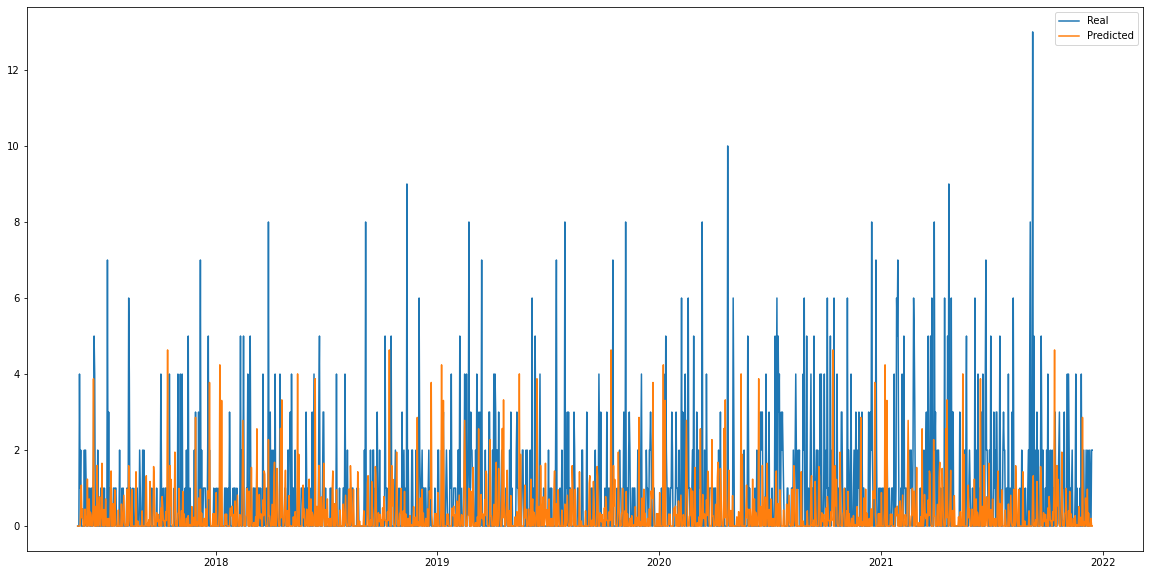

In [211]:
model1 = STLForecast(mdma_train, ARIMA, period = 365)
res = model1.fit()
curr_fc = round(res.forecast(len(mdma_test)), 4)
mask = pd.to_numeric(curr_fc, errors='coerce').lt(0)
curr_fc.loc[mask] = 0
fc_df = pd.DataFrame(data=curr_fc.values, index=mdma_test.index)
rms = mean_squared_error(mdma_test, fc_df, squared=False)
print(rms)
plt.plot(mdma_test, label="Real")
plt.plot(fc_df, label="Predicted")
plt.legend()
plt.show()


<h2> Predict with Arima</h2>

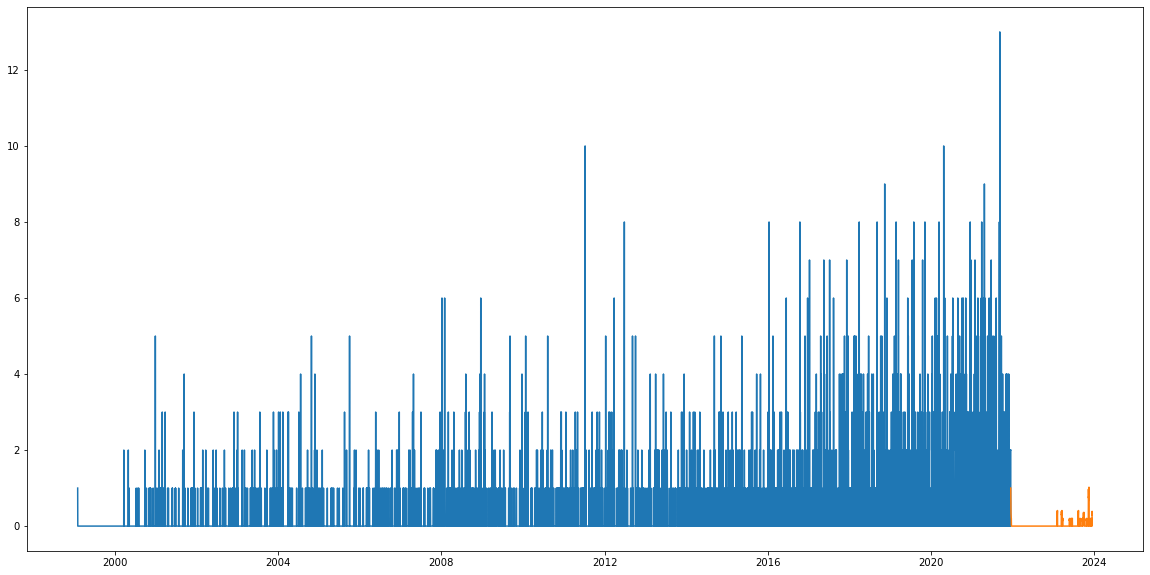

In [208]:
days_to_predict = 730
model1 = ARIMA(daily_mdma_result, order=(5,1,0))
res = model1.fit()
curr_fc = round(res.predict(1, days_to_predict), 4)
mask = pd.to_numeric(curr_fc, errors='coerce').lt(0)
curr_fc.loc[mask] = 0
base = daily_mdma_result.iloc[-1].name
date_list = [base + datetime.timedelta(days=x) for x in range(days_to_predict)]
fc_df = pd.DataFrame(data=curr_fc.values, index=date_list)
plt.plot(daily_mdma_result)
plt.plot(fc_df)
plt.show()

<h2>Predict with Arima using STL</h2>

In [212]:
print(len(daily_mdma_result))

8351


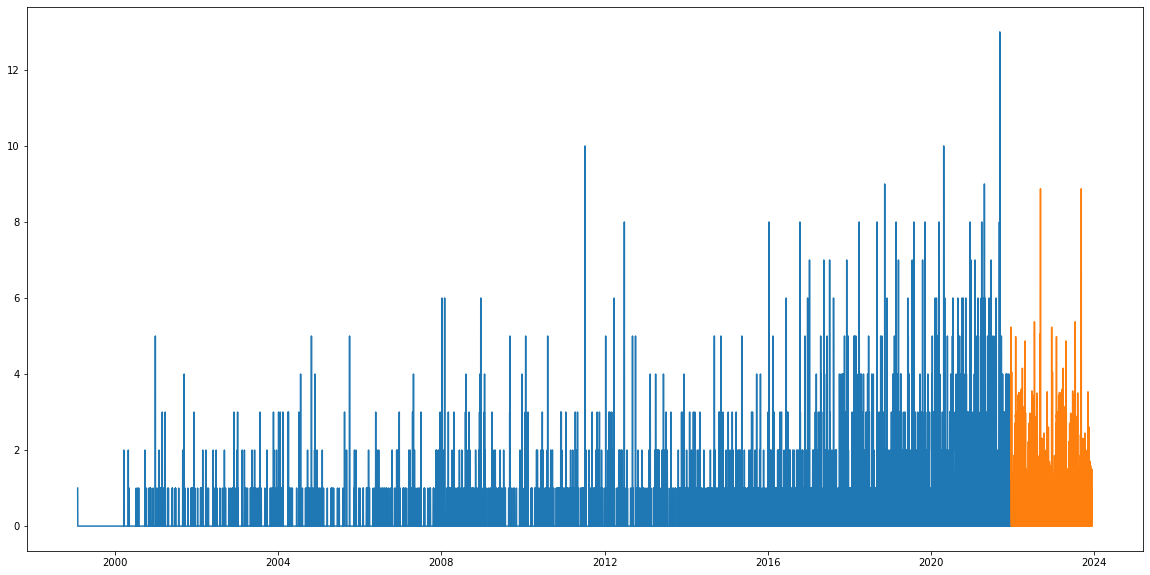

In [219]:
days_to_predict = 730
model1 = STLForecast(daily_mdma_result, ARIMA, period = 365)
res = model1.fit()
curr_fc = round(res.forecast(days_to_predict), 4)
mask = pd.to_numeric(curr_fc, errors='coerce').lt(0)
curr_fc.loc[mask] = 0
base = daily_mdma_result.iloc[-1].name
date_list = [base + datetime.timedelta(days=x) for x in range(days_to_predict)]
fc_df = pd.DataFrame(data=curr_fc.values, index=date_list)
plt.plot(daily_mdma_result)
plt.plot(fc_df)
plt.show()